# Baseline solution for Tiny ImageNet Challenge

You are presented with an opportunity to implement an Image Classifier for Tiny ImageNet dataset [same as used in CS231N](LINK). Tiny ImageNet contains 200 classes for training. Each class has 500 images. The test set contains 10,000 images. All images are 64x64 colored ones.

Your final goal is to demonstrate solid performance on the test split of the Tiny ImageNet dataset. We encourage you to show your thinking and demonstrate as many best practices along the way as you find appropriate.

We are looking for good analysis and presentation of the results, good problem decomposition and enough structure to allow for future foreseeable improvements. 

In [23]:
%%capture

from dataclasses import dataclass, replace
from pathlib import Path
from typing import Callable, List, Optional, Sequence, Union

import pandas as pd
import torch
import os
from pandas import DataFrame
from PIL import Image
from torch.utils.data.dataloader import default_collate
from torch.utils.data.dataset import Dataset
import sklearn
import numpy as np
from matplotlib import pyplot as plt

import numpy as np
from PIL import Image
from torchvision import transforms

from torchvision import models
from torch.nn.modules import loss
from torch import optim
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from tqdm.auto import tqdm

# Getting the data

a bit modified this part

In [2]:
! wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2021-07-14 21:10:27--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  17.3MB/s    in 13s     

2021-07-14 21:10:40 (17.5 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [ ]:
! mkdir data

! unzip tiny-imagenet-200.zip -d data

Unpacking our dataset will take a while, but it will only have to be done once.

Be prepared to wait next cell to finish up to 15 minutes

# Dataset

Here is a `TinyImagenetDataset` warpper you might find useful.

In [4]:
Transform = Callable[[Image.Image], Image.Image]


@dataclass()
class ItemsBatch:
    images: torch.Tensor
    labels: torch.Tensor
    ids: List[int]
    paths: List[Path]
    items: List["DatasetItem"]


@dataclass()
class DatasetItem:
    image: Union[torch.Tensor, Image.Image]
    label: int
    id: int
    path: Path

    @classmethod
    def collate(cls, items: Sequence["DatasetItem"]) -> ItemsBatch:
        if not isinstance(items, list):
            items = list(items)
        return ItemsBatch(
            images=default_collate([item.image for item in items]),
            labels=default_collate([item.label for item in items]),
            ids=[item.id for item in items],
            paths=[item.path for item in items],
            items=items,
        )

In [5]:
DATA_ROOT = Path("/data/tiny-imagenet-200")
RESULTS_ROOT = Path("/results/")
CHECKPOINTS = RESULTS_ROOT / "checkpoints"
CHECKPOINTS.mkdir(parents=True, exist_ok=True)
TENSORBOARD_TAG = "first_try"
CKPT_NAME = "first_model.pth"
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [6]:
DATA_ROOT

PosixPath('/data/tiny-imagenet-200')

In [7]:
TRAIN_PATH = "data/tiny-imagenet-200/train"
VAL_PATH = "data/tiny-imagenet-200/val"
ALL_FOLDERS = [
    dir_name
    for r, d, f in os.walk(TRAIN_PATH)
    for dir_name in d
    if dir_name != "images"
]
FOLDERS_TO_NUM = {val: index for index, val in enumerate(ALL_FOLDERS)}

LABELS = pd.read_csv(
     "data/tiny-imagenet-200/words.txt", sep="\t", header=None, index_col=0)[1].to_dict()
VAL_LABELS = pd.read_csv(
    "data/tiny-imagenet-200/val/val_annotations.txt", sep="\t", header=None, index_col=0)[1].to_dict()

In [8]:
# LABELS

In [9]:
class TinyImagenetDataset(Dataset):
    _transform: Optional[Transform]
    _root: Path
    _df: DataFrame

    def __init__(self, path, transform: Optional[Transform] = None):
        self._transform = transform
        if not os.path.isdir(path):
            raise NotADirectoryError(f"{path} is not a directory.")
        all_files = [
            os.path.join(r, fyle)
            for r, d, f in os.walk(path)
            for fyle in f
            if ".JPEG" in fyle
        ]
        labels = [
            FOLDERS_TO_NUM.get(
                os.path.basename(f).split("_")[0],
                FOLDERS_TO_NUM.get(VAL_LABELS.get(os.path.basename(f))),
            )
            for f in all_files
        ]
        self._df = pd.DataFrame({"path": all_files, "label": labels})

    def __getitem__(self, index: int) -> DatasetItem:
        path, label = self._df.loc[index, :]
        image = Image.open(path).convert("RGB")
        if self._transform:
            image = self._transform(image)
        return DatasetItem(image=image, label=label, id=index, path=path)

    def __len__(self) -> int:
        return len(self._df)

# Training loop for baseline solution (I've called it model_0)

This is a very basic training pipeline intended to rid you of writing too much boilerplate code

In [14]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    ]
)

train_dataset = TinyImagenetDataset("data/tiny-imagenet-200/train", transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=True,
    collate_fn=DatasetItem.collate,
    num_workers=0,
)

test_dataset = TinyImagenetDataset("data/tiny-imagenet-200/val/images", transform)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=256,
    shuffle=True,
    collate_fn=DatasetItem.collate,
    num_workers=0,
)

In [15]:
def train(model, device, train_loader, optimizer, loss_function, epoch, writer):
    model.train()
    model.to(device)
    correct = 0
    train_loss = []
    for batch_idx, batch_data in enumerate(tqdm(train_loader)):
        data, target = batch_data.images.to(device), batch_data.labels.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    print(
        "Train Epoch: {} [ ({:.0f}%)]\tLoss: {:.6f}".format(
            epoch, 100.0 * correct / len(train_loader.dataset), loss.item()
        )
    )
    writer.add_scalar("train_loss_plot", loss.item(), global_step=epoch)
    writer.add_scalar(
        "train_accuracy_plot",
        100.0 * correct / len(train_loader.dataset),
        global_step=epoch,
    )

    


def test(model, device, test_loader, loss_function, epoch, writer):
    model.eval()
    model.to(device)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for idx, batch_data in enumerate(tqdm(test_loader)):
            data, target = batch_data.images.to(device), batch_data.labels.to(device)
            output = model(data)
            test_loss += loss_function(output, target).sum().item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )
    writer.add_scalar("test_loss_plot", test_loss, global_step=epoch)
    writer.add_scalar(
        "test_accuracy_plot",
        100.0 * correct / len(test_loader.dataset),
        global_step=epoch,
    )

In [16]:
model_0 = models.resnet18()
model_0.fc = nn.Linear(512, 200)
model_0 = model_0.to(DEVICE)

optimizer = optim.SGD(model_0.parameters(), lr=1e-3)

loss_function = loss.CrossEntropyLoss()

In [31]:
## let's train it for 5 epochs and see what we're getting there

for epoch in range(5):
    writer = SummaryWriter(RESULTS_ROOT / TENSORBOARD_TAG)
    # break  # You should probably remove this in your training loop

    train(model_0, DEVICE, train_loader, optimizer, loss_function, epoch, writer)
    test(model_0, DEVICE, test_loader, loss_function, epoch, writer)
    writer.close()


Train Epoch: 0 [ (1%)]	Loss: 5.289901




Test set: Average loss: 0.0211, Accuracy: 93/10000 (1%)




Train Epoch: 1 [ (1%)]	Loss: 5.236942




Test set: Average loss: 0.0210, Accuracy: 119/10000 (1%)




Train Epoch: 2 [ (2%)]	Loss: 5.234452




Test set: Average loss: 0.0209, Accuracy: 164/10000 (2%)




Train Epoch: 3 [ (2%)]	Loss: 5.124011




Test set: Average loss: 0.0208, Accuracy: 200/10000 (2%)




Train Epoch: 4 [ (3%)]	Loss: 5.124849




Test set: Average loss: 0.0207, Accuracy: 214/10000 (2%)



poor results, it was expected. confusion matrix:

In [34]:
import sklearn
import numpy as np
from matplotlib import pyplot as plt

In [36]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([200, 200], int)

with torch.no_grad():
    for item in tqdm(test_loader):
        images, labels = item.images.to(DEVICE), item.labels.to(DEVICE)
        outputs = model_0(images)
        _, predicted = torch.max(outputs.data, 1)

        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1

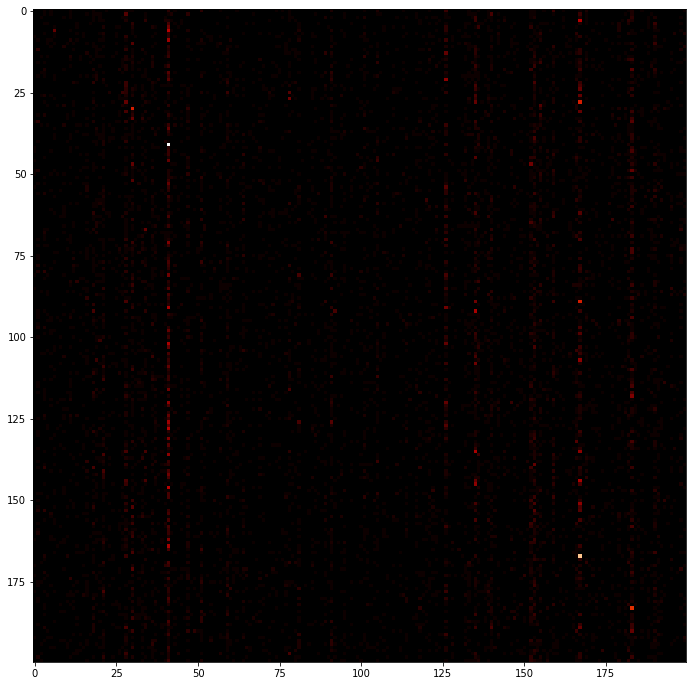

In [37]:
plt.figure(figsize=(12, 12))
plt.imshow(confusion_matrix, cmap="gist_heat", interpolation="nearest")
plt.show()

==========================

Now, when we have some poor baseline model let's think how this might be improved. First of all, 
* a small googling on Tiny Imagenet benchmarking shows a highest result of 85% accuracy on val dataset (https://paperswithcode.com/sota/image-classification-on-tiny-imagenet-1). Obviously this is a very good result but very far from results that might be received in the framework of one-evening-test-solution;
* a bit more of googling shows 75% on val and 78% on test datasets using inception-resnet-2 (https://towardsdatascience.com/transfer-learning-in-action-from-imagenet-to-tiny-imagenet-b96fe3aa5973);
* kaggle course challenge shows interesting 82% top result followed by 46% as a second result (https://www.kaggle.com/c/thu-deep-learning/leaderboard);
* also from the benchmark we see 60% on DenseNet with some residual nets (https://paperswithcode.com/sota/image-classification-on-tiny-imagenet-1);
* finally, a small research on Stanford 231 course reports shows that results vary from 45-50% using rather simple NN structures (VGG, ResNet, etc). 

Based on this analysis and limited time think 50-55% accuracy on val dataset will be good. Some insights from my previous experience with NN design: 
* usage of huge pre-trained networks as feature extractors for this type of poor-quality image datasets is absolutely pointless;
* also as of poor quality of pics almost no hyperparameter tuning might be done - using just SGD/Adam with moreless default parameters is enough;
* writing down a lot of layers on the top of feature-extractor network is not making sense - my experience shows that just one BatchNormalization, Dropout and Dense layers are enough;
* data augmentation might or might not help: pics are too small, blurred, poor quality - just experiment with them;
* using pretrained weights of feature extractor nets is a good idea; but they could be a bit tuned during training - also a good idea;
* generally speaking small amount of epochs is enought to check if the net is doing good (5-10) and check if it is learning something/overfitting/etc.;
* and so on (also, my experience shows that for this type of datasets VGG-type networks are doing well. They are simple and hence fast trainable. Also simple ResNet's are a bit better - ResNet18 or ResNet50 are doing very well! No fanaticism like ResNet151 and so on :)

Further I've played a bit with model adding all the stuff mentioned above and finally picked the following one:

In [39]:
model_1 = models.resnet18(pretrained=True) 

# # for param in model.parameters():
# #     param.requires_grad = False

# model_1.dp = nn.Dropout(0.5)
model_1.fc = nn.Linear(512, 200)

model_1 = model_1.to(DEVICE)

optimizer = optim.SGD(model_1.parameters(), lr=1e-3, momentum=0.9)

loss_function = loss.CrossEntropyLoss()

Let's train it for 5 epochs.

In [41]:
for epoch in range(5):
    writer = SummaryWriter(RESULTS_ROOT / TENSORBOARD_TAG)
    # break  # You should probably remove this in your training loop

    train(model_1, DEVICE, train_loader, optimizer, loss_function, epoch, writer)
    test(model_1, DEVICE, test_loader, loss_function, epoch, writer)
    writer.close()


Train Epoch: 0 [ (16%)]	Loss: 3.240064




Test set: Average loss: 0.0127, Accuracy: 3179/10000 (32%)




Train Epoch: 1 [ (39%)]	Loss: 2.432853




Test set: Average loss: 0.0100, Accuracy: 4267/10000 (43%)




Train Epoch: 2 [ (48%)]	Loss: 1.803442




Test set: Average loss: 0.0089, Accuracy: 4732/10000 (47%)




Train Epoch: 3 [ (53%)]	Loss: 2.129483




Test set: Average loss: 0.0083, Accuracy: 4955/10000 (50%)




Train Epoch: 4 [ (58%)]	Loss: 1.837288




Test set: Average loss: 0.0080, Accuracy: 5053/10000 (51%)



This model in just 5 epochs gets >50% accuracy on val dataset. 
Confusion matrix:

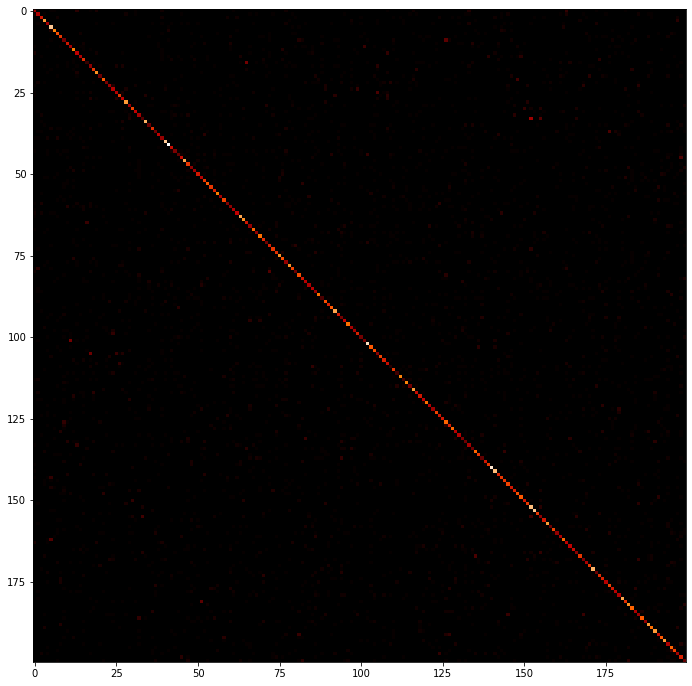

In [42]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([200, 200], int)

with torch.no_grad():
    for item in tqdm(test_loader):
        images, labels = item.images.to(DEVICE), item.labels.to(DEVICE)
        outputs = model_1(images)
        _, predicted = torch.max(outputs.data, 1)

        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1

plt.figure(figsize=(12, 12))
plt.imshow(confusion_matrix, cmap="gist_heat", interpolation="nearest")
plt.show()

In [43]:
torch.save(model_1, "my_model_resnet18_5_epochs.h")

However, training it more leads to overfitting as train score is >95% while val score is not improving and is around 50-55%. This effect was reported in different reports (http://cs231n.stanford.edu/reports/2016/pdfs/401_Report.pdf), and of course I also faced it while training it for 25 epochs.

In [11]:
for epoch in range(25):
    writer = SummaryWriter(RESULTS_ROOT / TENSORBOARD_TAG)
    # break  # You should probably remove this in your training loop

    train(model, DEVICE, train_loader, optimizer, loss_function, epoch, writer)
    test(model, DEVICE, test_loader, loss_function, epoch, writer)
    writer.close()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Train Epoch: 0 [ (17%)]	Loss: 3.296144




Test set: Average loss: 0.0126, Accuracy: 3204/10000 (32%)




Train Epoch: 1 [ (40%)]	Loss: 2.345711




Test set: Average loss: 0.0099, Accuracy: 4221/10000 (42%)




Train Epoch: 2 [ (48%)]	Loss: 1.998579




Test set: Average loss: 0.0089, Accuracy: 4679/10000 (47%)




Train Epoch: 3 [ (53%)]	Loss: 1.790342




Test set: Average loss: 0.0084, Accuracy: 4866/10000 (49%)




Train Epoch: 4 [ (58%)]	Loss: 1.862097




Test set: Average loss: 0.0081, Accuracy: 5057/10000 (51%)




Train Epoch: 5 [ (62%)]	Loss: 1.491440




Test set: Average loss: 0.0078, Accuracy: 5134/10000 (51%)




Train Epoch: 6 [ (65%)]	Loss: 1.458190




Test set: Average loss: 0.0078, Accuracy: 5203/10000 (52%)




Train Epoch: 7 [ (69%)]	Loss: 1.492230




Test set: Average loss: 0.0077, Accuracy: 5242/10000 (52%)




Train Epoch: 8 [ (72%)]	Loss: 1.163405




Test set: Average loss: 0.0077, Accuracy: 5285/10000 (53%)




Train Epoch: 9 [ (75%)]	Loss: 1.004687




Test set: Average loss: 0.0077, Accuracy: 5299/10000 (53%)




Train Epoch: 10 [ (78%)]	Loss: 1.139277




Test set: Average loss: 0.0076, Accuracy: 5312/10000 (53%)




Train Epoch: 11 [ (81%)]	Loss: 0.754485




Test set: Average loss: 0.0078, Accuracy: 5304/10000 (53%)




Train Epoch: 12 [ (84%)]	Loss: 0.666228




Test set: Average loss: 0.0079, Accuracy: 5292/10000 (53%)




Train Epoch: 13 [ (87%)]	Loss: 0.641867




Test set: Average loss: 0.0080, Accuracy: 5265/10000 (53%)




Train Epoch: 14 [ (89%)]	Loss: 0.606315




Test set: Average loss: 0.0081, Accuracy: 5254/10000 (53%)




Train Epoch: 15 [ (91%)]	Loss: 0.455659




Test set: Average loss: 0.0082, Accuracy: 5249/10000 (52%)




Train Epoch: 16 [ (93%)]	Loss: 0.423025




Test set: Average loss: 0.0083, Accuracy: 5210/10000 (52%)




Train Epoch: 17 [ (95%)]	Loss: 0.294584




Test set: Average loss: 0.0084, Accuracy: 5194/10000 (52%)




Train Epoch: 18 [ (96%)]	Loss: 0.267322




Test set: Average loss: 0.0085, Accuracy: 5180/10000 (52%)




Train Epoch: 19 [ (97%)]	Loss: 0.268213




Test set: Average loss: 0.0087, Accuracy: 5150/10000 (52%)




Train Epoch: 20 [ (98%)]	Loss: 0.231311




Test set: Average loss: 0.0089, Accuracy: 5148/10000 (51%)




Train Epoch: 21 [ (99%)]	Loss: 0.207498




Test set: Average loss: 0.0090, Accuracy: 5150/10000 (52%)




Train Epoch: 22 [ (99%)]	Loss: 0.179113


KeyboardInterrupt: ignored

Now I'll give a small report on all my tries of different models (x/x stands for train/val accuracy):
* baseline resnet18, Linear(512,200):

epoch1: 1/1, 	epoch2: 1/1, 		epoch3: 2/2, 		epoch4: 2/2, 		epoch5: 3/2

* resnet18, pretrained, non-trainable layers, Linear(512,200): 

epoch1: 6/14, 	epoch2: 19/23, 		epoch3: 26/26, 		epoch4: 29/28, 		epoch5: 30/30

* resnet18, pretrained, trainable layers, Linear(512,200): 

epoch1: 16/32, 	epoch2: 39/42, 		epoch3: 48/47, 		epoch4: 53/50, 		epoch5: 58/51


* resnet18, pretrained, trainable layers, BN, dropout(0.5), Linear(512,200):

epoch1: 16/31, 	epoch2: 39/42, 		epoch3: 48/46, 		epoch4: 53/49, 		epoch5: 57/50  

* resnet18, pretrained, trainable layers, data augmentation, BN, dropout(0.5), Linear(512,200):

epoch1: 7/6, 	epoch2: 19/11, 		epoch3: 35/17, 		epoch4: 48/17, 		epoch5: x/17 


* DenseNet, pretrained, trainable layers, Linear(512,200):

epoch1: 6/16, 	epoch2: 26/35 		

I've tried something more, but hadn't saved the results. Anyways, think that from all these models ResNet18 with pretrained weights with just one fully connected layer on it (+ of course softmax in CrossEntrophyLoss + of course a small fine-tuning of weights) showed acceptable results gained in just a couple of hours of playing with this dataset.
Also interestengly data augmentation, BN, Dropouts hadn't significantly affected the result (which I can explain with the initial small size of pics, just 64x64: for sure on imagenet or something similar with pic size say 224x224 will be significantly improved using these technics, as I've played a lot with them).

I decided to stop here as seems that this result is not very far from the limit reported (+ moreless the same for VGG19  https://learningai.io/projects/2017/06/29/tiny-imagenet.html ). Looks like I sensed the underlying problems/challenges with this dataset and don't think it is worth spending time on further improvements (within this test problem) :) However, surely further research might be done (like taking the worst classified classes, design a clever data augmentator that will generate more pics for these poorly-classified classes or something else). 